In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
currentDirectory = os.getcwd()
os.chdir(os.path.dirname(currentDirectory))
from TDOA_estimation import EllipticFilter, GCC_PHAT, CrossCorr
import time
from scipy.signal import filtfilt, ellip, freqz, lfilter
import matplotlib.pyplot as plt



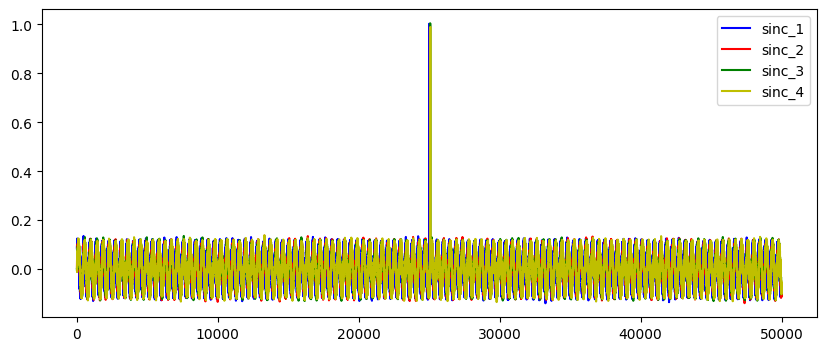

In [6]:
addNoise = True

fs = 100000  # Sampling frequency in Hz
length = 50000  # Length of the signal
frequency = 40000  # Frequency of the sinc functions

offset2 = 54  # Offset between the sinc functions
offset3 = 70  # Offset between the sinc functions
offset4 = 76  # Offset between the sinc functions


x1 = np.linspace(-length / 2, length / 2, length, endpoint=False)
x2 = x1 - offset2
x3 = x1 - offset3
x4 = x1 - offset4

signal_1 = np.sinc(frequency * x1) + .1*np.sin(x1/70)
signal_2 = np.sinc(frequency * (x2))  + .1*np.sin(x2/70)
signal_3 = np.sinc(frequency * (x3)) + .1*np.sin(x3/70)
signal_4 = np.sinc(frequency * (x4))  + .1*np.sin(x4/70)

trueTDOAs = np.array([[0,0,0,0],[ - offset2,  0,  0,  0],[- offset3, -(offset3 - offset2),  0,  0],[-offset4, - (offset4 - offset2), -(offset4 - offset3),  0]]) / fs


noiseScale = .01
if addNoise:
    signal_1 = signal_1 + np.random.normal(scale=noiseScale, size=len(signal_1))
    signal_2 = signal_2 + np.random.normal(scale=noiseScale, size=len(signal_1))
    signal_3 = signal_3 + np.random.normal(scale=noiseScale, size=len(signal_1))
    signal_4 = signal_4 + np.random.normal(scale=noiseScale, size=len(signal_1))

plt.figure(figsize=(10,4))
plt.plot(signal_1,c= 'b', label = "sinc_1")
plt.plot(signal_2, c= 'r', label = "sinc_2")
plt.plot(signal_3,c= 'g', label = "sinc_3")
plt.plot(signal_4, c= 'y', label = "sinc_4")
plt.legend()
plt.show()

## Produce and Visualize Elliptic filter

b coefficients: [ 0.49580191 -1.9260157   2.8613285  -1.9260157   0.49580191]
a coefficients: [ 1.         -2.53934052  2.67821627 -1.31270499  0.26392123]


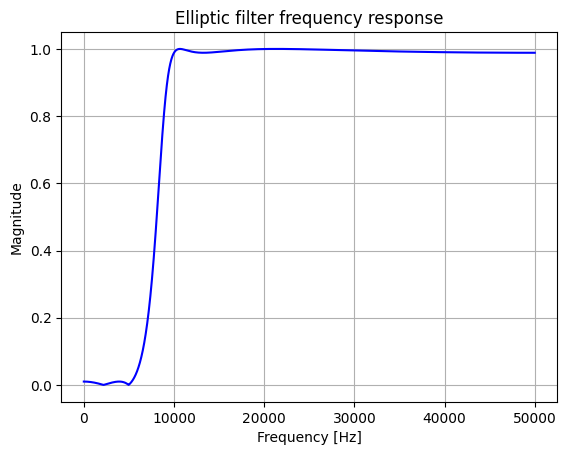

'\nnewSig = signal_2 + .1*np.sin(x/70)\nplt.plot(newSig)\nplt.show()\nfiltered_signal = filtfilt(b, a, newSig)\nplt.plot(filtered_signal)\nplt.show()\n\nprint("Rune time test: ")\nfilterStartTime = time.time()\nN = 1000\nfor i in range(N):\n    xxx = filtfilt(b, a, newSig)\nrunTime = time.time() - filterStartTime\nprint(runTime / N)\n'

In [3]:
order = 4
ripple_db = 0.1
cutoff_freq = 10000
sample_rate = 100000

b, a = EllipticFilter(order, ripple_db, cutoff_freq, sample_rate)
# Print coefficients
print("b coefficients:", b)
print("a coefficients:", a)

# Frequency response
w, h = freqz(b, a, worN=8000)
plt.figure()
plt.plot(0.5*sample_rate*w/np.pi, np.abs(h), 'b')
plt.title("Elliptic filter frequency response")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid()
plt.show()
"""
newSig = signal_2 + .1*np.sin(x/70)
plt.plot(newSig)
plt.show()
filtered_signal = filtfilt(b, a, newSig)
plt.plot(filtered_signal)
plt.show()

print("Rune time test: ")
filterStartTime = time.time()
N = 1000
for i in range(N):
    xxx = filtfilt(b, a, newSig)
runTime = time.time() - filterStartTime
print(runTime / N)
"""

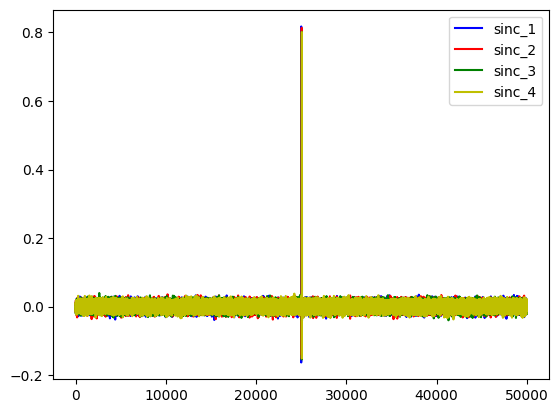

TDOA using cross-correlation: 
[[ 0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [-5.4e-04  0.0e+00  0.0e+00  0.0e+00]
 [-7.0e-04 -1.6e-04  0.0e+00  0.0e+00]
 [-7.6e-04 -2.2e-04 -6.0e-05  0.0e+00]]
Runtime:  6.439162015914917
Error: 
0.0
TDOA using GCC-PHAT: 
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-5.40000e-04  0.00000e+00  0.00000e+00  0.00000e+00]
 [-7.00000e-04 -1.60000e-04  0.00000e+00  0.00000e+00]
 [-7.60625e-04 -2.20000e-04 -6.00000e-05  0.00000e+00]]
Runtime:  0.09547591209411621
Error: 
6.249999999999745e-07


In [4]:
signal_1_fir = filtfilt(b, a, signal_1)
signal_2_fir = filtfilt(b, a, signal_2)
signal_3_fir = filtfilt(b, a, signal_3)
signal_4_fir = filtfilt(b, a, signal_4)



plt.plot(signal_1_fir,c= 'b', label = "sinc_1")
plt.plot(signal_2_fir, c= 'r', label = "sinc_2")
plt.plot(signal_3_fir,c= 'g', label = "sinc_3")
plt.plot(signal_4_fir, c= 'y', label = "sinc_4")
plt.legend()
plt.show()

dataMatrix = np.vstack(np.array([signal_1_fir, signal_2_fir,signal_3_fir, signal_4_fir]))


# Calculate TDOA using cross-correlation
startTime = time.time()
tdoa_cross_corr = CrossCorr(dataMatrix, fs)
print("TDOA using cross-correlation: ")
print(tdoa_cross_corr)
print("Runtime: ", time.time() - startTime)
print("Error: ")
print(np.sqrt(np.sum((tdoa_cross_corr - trueTDOAs)**2)))


NewstartTime = time.time()
offset = GCC_PHAT(dataMatrix, fs,max_tau=None, interp=16)
print("TDOA using GCC-PHAT: ")
print(offset)
print("Runtime: ", time.time() - NewstartTime)
print("Error: ")
print(np.sqrt(np.sum((offset - trueTDOAs)**2)))

In [5]:
print("Run time test: ")
filterStartTime = time.time()
N = 100000
for i in range(N):
    xxx = filtfilt(b, a, signal_1)

runTime = time.time() - filterStartTime
print("{:e}".format(runTime / N))

Run time test: 
8.160650e-04
